In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
#from mpl_toolkits.basemap import Basemap
#import folium
#from folium import plugins as f_plugins
#import fiona
import shapely
import pandas as pd
import seaborn as sns
import tables
from dateutil import tz
from string import ascii_lowercase as alphabet
import matplotlib.dates as mdates
import pickle

In [2]:
def load_SABRE_file(sabre_out_dir):
    
    sabre_out_fls = os.listdir(sabre_out_dir)
    sabre_ITS_path = os.sep.join([sabre_out_dir,[s for s in sabre_out_fls if "_ITS.txt" in s][0]])
    sabre_ITS = pd.read_csv(sabre_ITS_path,sep=',')

    best_est_name = sabre_ITS.Trial_Name[sabre_ITS.Trial_Name.str.contains("BestEstimate")][0]
    print('Loading Best Estimate')
    SABRE_all_trails = gpd.read_file(os.sep.join([sabre_out_dir,'Results',best_est_name+'_grid.shp']))
    SABRE_all_trails['Trial_Name'] = best_est_name
    SABRE_all_trails['Time'] = pd.to_datetime(sabre_ITS.Ignition_Time[sabre_ITS.Trial_Name.str.contains("BestEstimate")][0])

    #Make a copy of dataframe where spotting exists
    spot = SABRE_all_trails.dropna(subset = ['HOUR_SPOT']).copy()
    spot['Grid_Type'] = 'Spot'

    spot['Time'] = spot['Time'] + pd.to_timedelta(spot['HOUR_SPOT'],unit='h')


    #Trim trial
    SABRE_all_trails = SABRE_all_trails.dropna(subset = ['HOUR_BURNT'])
    SABRE_all_trails['Grid_Type'] = 'Fire'

    SABRE_all_trails['Time'] = SABRE_all_trails['Time'] + pd.to_timedelta(SABRE_all_trails['HOUR_BURNT'],unit='h')

    #Recombine
    SABRE_all_trails = pd.concat([SABRE_all_trails,spot])

    del spot

    for trial_name in sabre_ITS.Trial_Name[sabre_ITS.Trial_Name.str.contains("Trial")]:
        SABRE_trial = gpd.read_file(os.sep.join([sabre_out_dir,'Results',trial_name+'_grid.shp']))
        SABRE_trial['Time'] = pd.to_datetime(sabre_ITS.Ignition_Time[sabre_ITS.Trial_Name == trial_name]).iloc[0]
        #Make a copy of dataframe where spotting exists
        spot = SABRE_trial.dropna(subset = ['HOUR_SPOT']).copy()
        spot['Grid_Type'] = 'Spot'
        spot['Time'] = spot['Time'] + pd.to_timedelta(spot['HOUR_SPOT'],unit='h')

        #Trim trial
        SABRE_trial = SABRE_trial.dropna(subset = ['HOUR_BURNT'])
        SABRE_trial['Grid_Type'] = 'Fire'
        SABRE_trial['Time'] = SABRE_trial['Time'] + pd.to_timedelta(SABRE_trial['HOUR_BURNT'],unit='h')

        SABRE_trial = pd.concat([SABRE_trial,spot],sort=False)
        SABRE_trial['Trial_Name'] = trial_name
        #print(SABRE_trial['Trial_Name'].shape)
        print('Joining '+ trial_name)
        #print(SABRE_trial.shape[0])
        del spot
        SABRE_all_trails = pd.concat([SABRE_all_trails,SABRE_trial],sort=False)
        #print(SABRE_all_trails.shape[0])
        del SABRE_trial

    SABRE_all_trails['Time_obj'] = SABRE_all_trails['Time'].dt.round('min')
    #SABRE_all_trails['Time'] = SABRE_all_trails['Time'].dt.round('1s').astype(str)
    
    return SABRE_all_trails


In [3]:
sabre_out_dir = './datasets/SABRE/Rand_Sedgerly_5Dec1215To1900_2016125/'
Sedgerly_5Dec1215To1900 = load_SABRE_file(sabre_out_dir)
#sabre_out_dir = './SABRE/Rand_Sedgerly_5Dec_Ignto1215Scar_2016125/'
#Sedgerly_5Dec_Ignto1215 = load_SABRE_file(sabre_out_dir)

#Sedgerly_Ignition_to_1900 = pd.concat([Sedgerly_5Dec1215To1900,Sedgerly_5Dec_Ignto1215],sort=False)
#Sedgerly_Ignition_to_1900.reset_index(drop=True,inplace=True)

Loading Best Estimate
Joining Rand_Sedgerly_5Dec1215To1900_Trial_1
Joining Rand_Sedgerly_5Dec1215To1900_Trial_2
Joining Rand_Sedgerly_5Dec1215To1900_Trial_3
Joining Rand_Sedgerly_5Dec1215To1900_Trial_4
Joining Rand_Sedgerly_5Dec1215To1900_Trial_5
Joining Rand_Sedgerly_5Dec1215To1900_Trial_6
Joining Rand_Sedgerly_5Dec1215To1900_Trial_7
Joining Rand_Sedgerly_5Dec1215To1900_Trial_8
Joining Rand_Sedgerly_5Dec1215To1900_Trial_9
Joining Rand_Sedgerly_5Dec1215To1900_Trial_10
Joining Rand_Sedgerly_5Dec1215To1900_Trial_11
Joining Rand_Sedgerly_5Dec1215To1900_Trial_12
Joining Rand_Sedgerly_5Dec1215To1900_Trial_13
Joining Rand_Sedgerly_5Dec1215To1900_Trial_14
Joining Rand_Sedgerly_5Dec1215To1900_Trial_15
Joining Rand_Sedgerly_5Dec1215To1900_Trial_16
Joining Rand_Sedgerly_5Dec1215To1900_Trial_17
Joining Rand_Sedgerly_5Dec1215To1900_Trial_18
Joining Rand_Sedgerly_5Dec1215To1900_Trial_19
Joining Rand_Sedgerly_5Dec1215To1900_Trial_20
Joining Rand_Sedgerly_5Dec1215To1900_Trial_21
Joining Rand_Sedgerly

In the Phoenix output files, the spotting field is stored in the same shapefile, meaning if it's left in there'll be duplicate timestamps. Remove it.

In [4]:
Sedgerly_5Dec1215To1900[~Sedgerly_5Dec1215To1900.Grid_Type.str.contains("Spot")]
Sedgerly_5Dec1215To1900.reset_index(drop=True,inplace=True)

In [469]:
Sedgerly_5Dec1215To1900[Sedgerly_5Dec1215To1900.Trial_Name == 'Rand_Sedgerly_5Dec1215To1900_BestEstimate'].FFDI.idxmax()

2096

In [470]:
Sedgerly_5Dec1215To1900.iloc[2096]

CELL_ID                                                  195569
S_SLOPE                                                 1.82858
S_ELEVTN                                                411.031
S_ASPECT                                                78.1916
F_GRASS                                                    None
F_SURFACE                                                 10.21
F_BARK                                                      1.4
F_ELVTD                                                    0.35
F_TOTAL                                                   11.96
ROAD_PROX                                               479.947
DISRUPTION                                                  NaN
HOUR_BURNT                                              2.45926
E_ROS                                                   394.543
E_INTSTY                                                2434.87
HOUR_SPOT                                                   NaN
SPOT_DIST                               

In [5]:
Sedgerly_mean = Sedgerly_5Dec1215To1900.resample('T', on='Time_obj').mean()
resampled_std = Sedgerly_5Dec1215To1900.resample('T', on='Time_obj').std() #.dropna(how='all')
Sedgerly_mean_std = Sedgerly_mean.join(resampled_std,lsuffix='_mean',rsuffix='_std')
Sedgerly_mean_std.reset_index(inplace=True)
#Sedgerly_mean_std.dropna(inplace=True)
Sedgerly_mean_std.head()


,Time_obj,CELL_ID_mean,S_SLOPE_mean,S_ELEVTN_mean,S_ASPECT_mean,F_SURFACE_mean,F_BARK_mean,F_ELVTD_mean,F_TOTAL_mean,ROAD_PROX_mean,...,FLAME_DT_std,CONVECT_std,FMC_std,FFDI_std,WIND_SPD_std,WIND_DIR_std,IMPACT_DIR_std,HL_PROB_std,X_COORD_std,Y_COORD_std
0,2016-12-05 12:15:00,212401.854612,2.796043,434.821336,161.973297,9.081656,0.761954,1.740251,11.583860,824.370167,...,1.084868,934.038149,0.385802,3.845121,2.231278,11.587514,117.843720,0.002832,616.136867,376.287376
1,2016-12-05 12:16:00,222793.934685,2.452262,435.776804,167.093575,8.983266,0.658964,2.007703,11.649932,874.140347,...,0.846914,1028.365139,0.260680,3.929405,2.394511,12.407413,147.485779,0.003555,586.427369,158.058431
2,2016-12-05 12:17:00,222917.350467,2.332607,437.826116,153.157475,9.018505,0.660654,2.006121,11.685280,901.299013,...,0.833631,1016.346750,0.274506,3.903187,2.366157,12.922146,153.439389,0.003652,579.302089,159.792526
3,2016-12-05 12:18:00,222269.006557,1.936138,434.077269,171.127487,8.986951,0.669607,1.930951,11.587508,930.752565,...,0.892726,1154.249572,0.260682,3.724087,2.620815,14.013253,147.706307,0.004640,621.751171,173.630845
4,2016-12-05 12:19:00,221557.362805,1.969263,435.122120,168.180251,9.012195,0.676128,2.020457,11.708780,924.604620,...,0.856149,1084.085033,0.247421,3.985938,2.290175,11.954344,140.782151,0.004329,645.543166,182.989436


## Get out key timestamps from the other plots

In [6]:
plot_set_timestamps_15M = pickle.load( open( "./datasets/plot_set_timestamps_15M.pickle", "rb" ) )

## Localize the timezone, all SABRE runs were done in local time

In [7]:
Sedgerly_mean_std['Time_obj'] = Sedgerly_mean_std.Time_obj.dt.tz_localize('Australia/Brisbane')

## Make a plot of the mean and standard deviation of flame height

/Users/Fuego/anaconda3/envs/radar/lib/python3.7/site-packages/seaborn/relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)
/Users/Fuego/anaconda3/envs/radar/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


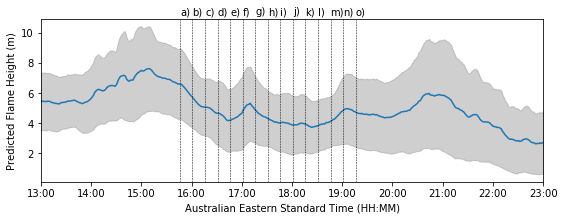

In [8]:
target_tz = 'Australia/Brisbane'

#fig, ax=plt.Figure(figsize=(10,5))
#cis = (Sedgerly_mean_std.FLAME_HT_mean - Sedgerly_mean_std.FLAME_HT_std, Sedgerly_mean_std.FLAME_HT_mean + Sedgerly_mean_std.FLAME_HT_std)
cis = (Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean() - Sedgerly_mean_std.FLAME_HT_std, Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean() + Sedgerly_mean_std.FLAME_HT_std)

xtime = Sedgerly_mean_std.Time_obj.dt.tz_convert(target_tz)

fig, ax = plt.subplots(figsize=(9,3))
sns.lineplot(xtime,Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean())
#ns.lineplot(Sedgerly_mean_std.Time_obj,Sedgerly_mean_std.FLAME_HT_std)
top = Sedgerly_mean_std.FLAME_HT_mean + Sedgerly_mean_std.FLAME_HT_std
bottom = Sedgerly_mean_std.FLAME_HT_mean - Sedgerly_mean_std.FLAME_HT_std
ax.fill_between(xtime, bottom.rolling(10).mean(), top.rolling(10).mean(), color='#888888', alpha=0.4)
#ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
#ax.fill_between(Sedgerly_mean_std.Time_obj,cis[1],cis[0],alpha=0.2)
i = 0
for ts in plot_set_timestamps_15M:
    ax.axvline(ts.tz_convert(target_tz),color='k',linestyle='--',lw=0.5,label='test')
    #plt.text(ts.tz_convert(target_tz),0,ts.tz_convert(target_tz).strftime('%H:%M'),rotation=90)
    plt.text(ts.tz_convert(target_tz),11.2,alphabet[i]+')')#,rotation=90)
    i = i +1
plt.xlabel('Australian Eastern Standard Time (HH:MM)')
plt.ylabel('Predicted Flame Height (m)')
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))
plt.savefig('flameheigh_ts.png',dpi=300)
plt.show()

### Quick list of columns for reference

In [119]:
Sedgerly_mean_std.columns

Index(['Time_obj', 'CELL_ID_mean', 'S_SLOPE_mean', 'S_ELEVTN_mean',
       'S_ASPECT_mean', 'F_SURFACE_mean', 'F_BARK_mean', 'F_ELVTD_mean',
       'F_TOTAL_mean', 'ROAD_PROX_mean', 'DISRUPTION_mean', 'HOUR_BURNT_mean',
       'E_ROS_mean', 'E_INTSTY_mean', 'HOUR_SPOT_mean', 'SPOT_DIST_mean',
       'EMBR_DNSTY_mean', 'WENT_OUT_mean', 'FLAME_HT_mean', 'FLAME_DT_mean',
       'CONVECT_mean', 'FMC_mean', 'FFDI_mean', 'WIND_SPD_mean',
       'WIND_DIR_mean', 'IMPACT_DIR_mean', 'HL_PROB_mean', 'X_COORD_mean',
       'Y_COORD_mean', 'CELL_ID_std', 'S_SLOPE_std', 'S_ELEVTN_std',
       'S_ASPECT_std', 'F_SURFACE_std', 'F_BARK_std', 'F_ELVTD_std',
       'F_TOTAL_std', 'ROAD_PROX_std', 'DISRUPTION_std', 'HOUR_BURNT_std',
       'E_ROS_std', 'E_INTSTY_std', 'HOUR_SPOT_std', 'SPOT_DIST_std',
       'EMBR_DNSTY_std', 'WENT_OUT_std', 'FLAME_HT_std', 'FLAME_DT_std',
       'CONVECT_std', 'FMC_std', 'FFDI_std', 'WIND_SPD_std', 'WIND_DIR_std',
       'IMPACT_DIR_std', 'HL_PROB_std', 'X_COORD_std', '

### Get correlation between a few variables

In [14]:
Sedgerly_mean_std['FLAME_HT_mean'].corr(Sedgerly_mean_std['E_INTSTY_mean'])

0.9816798327112592

In [15]:
Sedgerly_mean_std['FLAME_HT_mean'].corr(Sedgerly_mean_std['E_ROS_mean'])

0.991673823910927

In [16]:
Sedgerly_mean_std.FLAME_HT_mean.max()

7.995256184276146

In [153]:
temp = Sedgerly_mean_std.copy().set_index(Sedgerly_mean_std.Time_obj) #.dt.tz_convert(target_tz)

In [157]:
Sedgerly_mean_std.FLAME_HT_mean.iloc[(temp.index.get_loc(plot_set_timestamps_15M[-4], method='nearest'))]

3.851598996421723

In [158]:
Sedgerly_mean_std.FLAME_HT_mean.iloc[(temp.index.get_loc(plot_set_timestamps_15M[-2], method='nearest'))]

4.9650876325950914

In [151]:
(xtime.get_loc(plot_set_timestamps_15M[-4], method='nearest'))

AttributeError: 'Series' object has no attribute 'get_loc'

/Users/Fuego/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


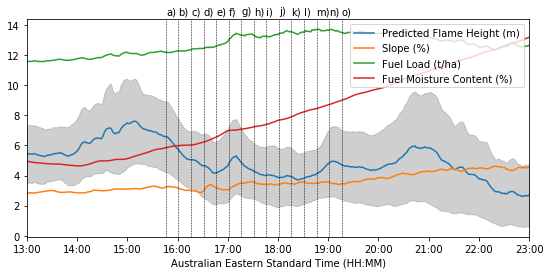

In [12]:
target_tz = 'Australia/Brisbane'

#fig, ax=plt.Figure(figsize=(10,5))
#cis = (Sedgerly_mean_std.FLAME_HT_mean - Sedgerly_mean_std.FLAME_HT_std, Sedgerly_mean_std.FLAME_HT_mean + Sedgerly_mean_std.FLAME_HT_std)
cis = (Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean() - Sedgerly_mean_std.FLAME_HT_std, Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean() + Sedgerly_mean_std.FLAME_HT_std)

xtime = Sedgerly_mean_std.Time_obj.dt.tz_convert(target_tz)

fig, ax = plt.subplots(figsize=(9,4))
handles = []
handles.append(sns.lineplot(xtime,Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean()))
handles.append(sns.lineplot(xtime,Sedgerly_mean_std.S_SLOPE_mean.rolling(10).mean()))
handles.append(sns.lineplot(xtime,Sedgerly_mean_std.F_TOTAL_mean.rolling(10).mean()))
handles.append(sns.lineplot(xtime,Sedgerly_mean_std.FMC_mean.rolling(10).mean()))
#handles.append(sns.lineplot(xtime,Sedgerly_mean_std.WIND_SPD_mean.rolling(10).mean()))

#E_ROS_mean

#F_TOTAL_mean

#ns.lineplot(Sedgerly_mean_std.Time_obj,Sedgerly_mean_std.FLAME_HT_std)
top = Sedgerly_mean_std.FLAME_HT_mean + Sedgerly_mean_std.FLAME_HT_std
bottom = Sedgerly_mean_std.FLAME_HT_mean - Sedgerly_mean_std.FLAME_HT_std
ax.fill_between(xtime, bottom.rolling(10).mean(), top.rolling(10).mean(), color='#888888', alpha=0.4)
#ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
#ax.fill_between(Sedgerly_mean_std.Time_obj,cis[1],cis[0],alpha=0.2)

plt.legend(handles,labels=['Predicted Flame Height (m)','Slope (%)','Fuel Load (t/ha)','Fuel Moisture Content (%)'],loc='upper right')


i = 0
for ts in plot_set_timestamps_15M:
    ax.axvline(ts.tz_convert(target_tz),color='k',linestyle='--',lw=0.5,label='test')
    #plt.text(ts.tz_convert(target_tz),0,ts.tz_convert(target_tz).strftime('%H:%M'),rotation=90)
    plt.text(ts.tz_convert(target_tz),14.7,alphabet[i]+')')#,rotation=90)
    i = i +1
plt.xlabel('Australian Eastern Standard Time (HH:MM)')
plt.ylabel('')
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))
plt.savefig('flameheigh_ts.png',dpi=300)
plt.show()

In [ ]:
def dt_parser(ts):
    return pd.to_datetime(ts, format='%d/%m/%Y %H:%M:%S')

def load_SABRE_weather(path,header):
    lightning = pd.read_csv(path,names=header,parse_dates=[7],date_parser=dt_parser)
    lightning.rename(columns={'_'.join(header[0:6]):'datetime'},inplace=True)
    lightning = lightning.set_index(['datetime'])
    return lightning
header = ['Firename','SABREname','trialname']

In [165]:
header = ['fire','run','Trial','uk1','model','uk2',
          'datetime','uk3','temperature','temperature_mod','rh','rh_mod','ws','ws_mod','wd','wd_mod',
          'Axis 1', '100', '96', '10', '8.9', '0', 'Unnamed: 22', '17.67']

In [166]:
sabre_weather = pd.read_csv('./datasets/SABRE/Rand_Sedgerly_5Dec1215To1900_2016125/Archived_Files/Weather_Inputs_Summary.txt', names=header)

In [167]:
sabre_weather['datetime'] = pd.to_datetime(sabre_weather.datetime,format='%d/%m/%Y %H:%M:%S').dt.tz_localize('Australia/Brisbane')

In [168]:
def format_trial_name(trial_name):
    return ' '.join(trial_name.split('_')[-2:])

sabre_weather['Trial'] = sabre_weather.Trial.apply(format_trial_name)

In [72]:
def clean_bom_timestamp(df,ts_string,target_tz):
    df[ts_string] = df[ts_string].dt.tz_localize('Australia/Brisbane')
    df.rename(columns={ts_string:'datetime'},inplace=True)
    return df

In [311]:
dalby_1min

,Year Month Day Hour Minutes in YYYY_MM_DD_HH24_MI format in Local standard time,hd,Station Number,* Precipitation since last synoptic observation in mm,* Quality of precipitation since last synoptic observation value,Air Temperature in degrees Celsius,Quality of air temperature,Wet bulb temperature in degrees Celsius,Quality of Wet bulb temperature,Dew point temperature in degrees Celsius,...,Wind (1 minute) speed quality,Wind (1 minute) direction in degrees true,Wind (1 minute) direction quality,Standard deviation of wind (1 minute),Standard deviation of wind (1 minute) direction quality,Maximum wind gust (over 1 minute) in km/h,Maximum wind gust (over 1 minute) quality,Mean sea level pressure in hPa,Quality of mean sea level pressure,#
0,2016 12 04 00 00,hd,41522,0.0,N,24.2,Y,17.5,Y,12.8,...,Y,62,Y,1,Y,13,Y,1013.2,Y,#
1,2016 12 04 00 01,hd,41522,,,24.1,Y,17.4,Y,12.7,...,Y,64,Y,1,Y,13,Y,1013.2,Y,#
2,2016 12 04 00 02,hd,41522,,,24.1,Y,17.4,Y,12.7,...,Y,65,Y,1,Y,13,Y,1013.2,Y,#
3,2016 12 04 00 03,hd,41522,,,24.0,Y,17.4,Y,12.6,...,Y,66,Y,1,Y,13,Y,1013.2,Y,#
4,2016 12 04 00 04,hd,41522,,,24.0,Y,17.5,Y,12.9,...,Y,69,Y,3,Y,13,Y,1013.1,Y,#
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,2016 12 07 23 55,hd,41522,,,25.0,Y,20.1,Y,17.2,...,Y,113,Y,3,Y,17,Y,1011.8,Y,#
5756,2016 12 07 23 56,hd,41522,,,25.0,Y,20.1,Y,17.2,...,Y,106,Y,4,Y,18,Y,1011.8,Y,#
5757,2016 12 07 23 57,hd,41522,,,25.0,Y,20.1,Y,17.2,...,Y,104,Y,5,Y,17,Y,1011.8,Y,#
5758,2016 12 07 23 58,hd,41522,,,25.0,Y,20.3,Y,17.5,...,Y,105,Y,2,Y,15,Y,1011.8,Y,#


In [336]:
dalby_1min = pd.read_csv('./datasets/WeatherData1_Dalby_1min/HD01D_Data_041522_999999999520484.txt',parse_dates=[[2,3,4,5,6]])
dalby_1min.rename(columns={'Year Month Day Hour Minutes in YYYY_MM_DD_HH24_MI format in Local standard time':'test'})
dt_str = ' Year Month Day Hour Minutes in YYYY_MM_DD_HH24_MI format in Local standard time'
dalby_1min[dt_str] = pd.to_datetime(dalby_1min[dt_str],format='%Y %m %d %H %M').dt.tz_localize('Australia/Brisbane')
dalby_1min.rename(columns={dt_str:'datetime'},inplace=True)

In [ ]:
target_tz='Australia/Brisbane'
ts_string = 'Day/Month/Year Hour24:Minutes in DD/MM/YYYY HH24:MI format in Local standard time'

dalby = pd.read_excel('./datasets/Copy of Darling Downs Observations 3 to 6 Dec 2016.xlsx',sheet_name=0)
oakey = pd.read_excel('./datasets/Copy of Darling Downs Observations 3 to 6 Dec 2016.xlsx',sheet_name=1)
warwick = pd.read_excel('./datasets/Copy of Darling Downs Observations 3 to 6 Dec 2016.xlsx',sheet_name=2)
wellcamp = pd.read_excel('./datasets/Copy of Darling Downs Observations 3 to 6 Dec 2016.xlsx',sheet_name=3)

dalby = clean_bom_timestamp(dalby,ts_string,target_tz)
oakey = clean_bom_timestamp(oakey,ts_string,target_tz)
warwick = clean_bom_timestamp(warwick,ts_string,target_tz)
wellcamp = clean_bom_timestamp(wellcamp,ts_string,target_tz)

In [76]:
dalby.columns

Index(['hm', 'Station Number', 'Station Name', 'datetime',
       'Precipitation since 9am local time in mm',
       'Air Temperature in degrees C', 'Dew point temperature in degrees C',
       'Relative humidity in percentage %', 'Wind speed in km/h',
       'Wind direction in degrees true',
       'Speed of maximum windgust in last 10 minutes in  km/h', '#'],
      dtype='object')

/Users/Fuego/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/Users/Fuego/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/Users/Fuego/.local/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


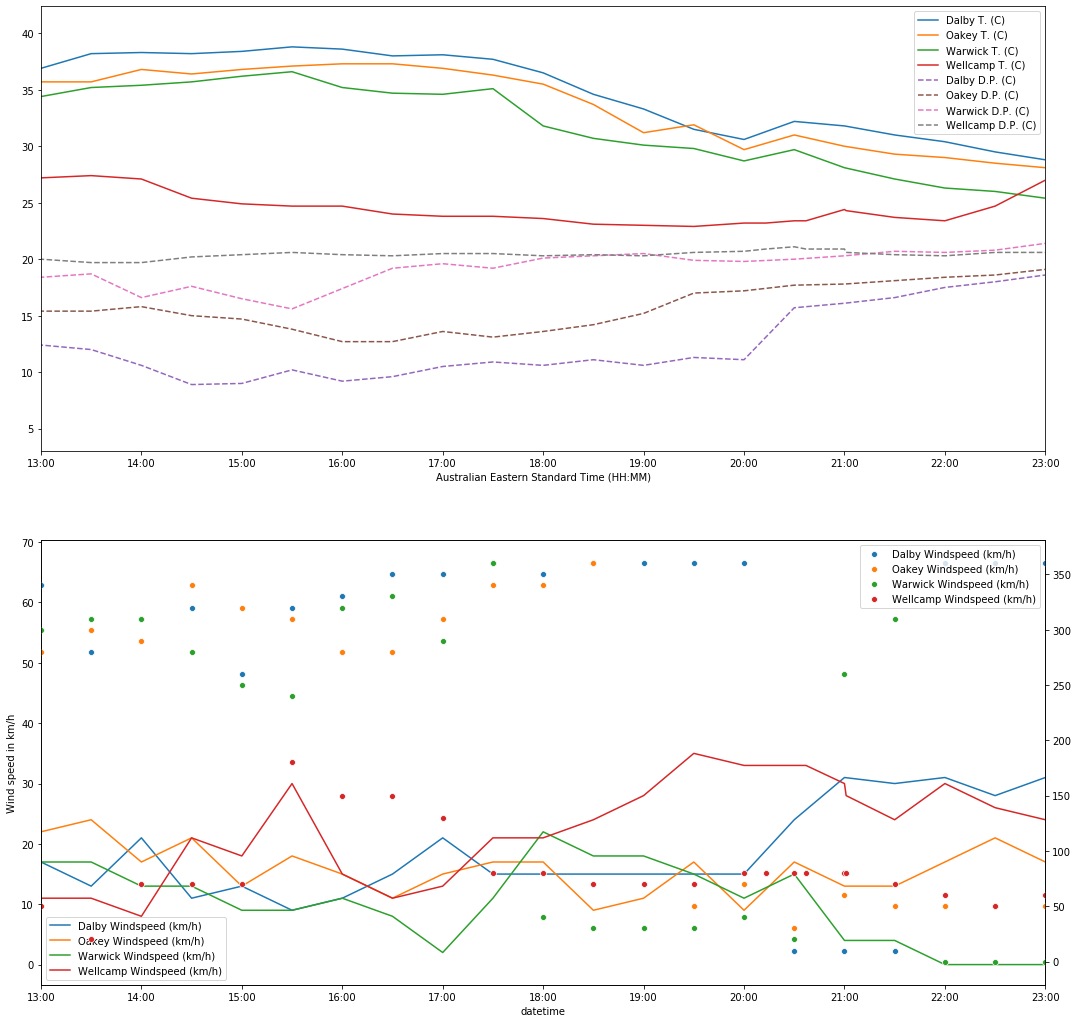

In [119]:
target_tz = 'Australia/Brisbane'

#fig, ax=plt.Figure(figsize=(10,5))
#cis = (Sedgerly_mean_std.FLAME_HT_mean - Sedgerly_mean_std.FLAME_HT_std, Sedgerly_mean_std.FLAME_HT_mean + Sedgerly_mean_std.FLAME_HT_std)
#cis = (Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean() - Sedgerly_mean_std.FLAME_HT_std, Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean() + Sedgerly_mean_std.FLAME_HT_std)

#xtime = Sedgerly_mean_std.Time_obj.dt.tz_convert(target_tz)

fig, ax = plt.subplots(figsize=(18,18))
ax1 = plt.subplot(211)
handles = []
handles.append(sns.lineplot(dalby['datetime'],dalby['Air Temperature in degrees C']))
handles.append(sns.lineplot(oakey['datetime'],oakey['Air Temperature in degrees C']))
handles.append(sns.lineplot(warwick['datetime'],warwick['Air Temperature in degrees C']))
handles.append(sns.lineplot(wellcamp['datetime'],wellcamp['Air Temperature in degrees C']))

handles.append(sns.lineplot(dalby['datetime'],dalby['Dew point temperature in degrees C']))
handles[0].lines[-1].set_linestyle("--")
handles.append(sns.lineplot(oakey['datetime'],oakey['Dew point temperature in degrees C']))
handles[0].lines[-1].set_linestyle("--")
handles.append(sns.lineplot(warwick['datetime'],warwick['Dew point temperature in degrees C']))
handles[0].lines[-1].set_linestyle("--")
handles.append(sns.lineplot(wellcamp['datetime'],wellcamp['Dew point temperature in degrees C']))
handles[0].lines[-1].set_linestyle("--")
aws_locations = ['Dalby','Oakey','Warwick','Wellcamp']
labels = [x + ' T. (C)' for x in aws_locations]
labels.extend([x + ' D.P. (C)' for x in aws_locations])
plt.legend(handles,labels=labels,loc='upper right')
    
plt.xlabel('Australian Eastern Standard Time (HH:MM)')
plt.ylabel('')
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))


ax2 = plt.subplot(212)
handles = []
handles.append(sns.lineplot(dalby['datetime'],dalby['Wind speed in km/h']))
handles.append(sns.lineplot(oakey['datetime'],oakey['Wind speed in km/h']))
handles.append(sns.lineplot(warwick['datetime'],warwick['Wind speed in km/h']))
handles.append(sns.lineplot(wellcamp['datetime'],wellcamp['Wind speed in km/h']))
aws_locations = ['Dalby','Oakey','Warwick','Wellcamp']
labels = [x + ' Windspeed (km/h)' for x in aws_locations]
#labels.extend([x + ' Wind Direction' for x in aws_locations])
plt.legend(handles,labels=labels,loc='lower left')
ax2 = ax2.twinx()
handles = []
handles.append(sns.scatterplot(dalby['datetime'],dalby['Wind direction in degrees true']))
handles.append(sns.scatterplot(oakey['datetime'],oakey['Wind direction in degrees true']))
handles.append(sns.scatterplot(warwick['datetime'],warwick['Wind direction in degrees true']))
handles.append(sns.scatterplot(wellcamp['datetime'],wellcamp['Wind direction in degrees true']))
# handles.append(sns.lineplot(dalby['datetime'],dalby['Dew point temperature in degrees C']))
# handles[0].lines[-1].set_linestyle("--")
# handles.append(sns.lineplot(oakey['datetime'],oakey['Dew point temperature in degrees C']))
# handles[0].lines[-1].set_linestyle("--")
# handles.append(sns.lineplot(warwick['datetime'],warwick['Dew point temperature in degrees C']))
# handles[0].lines[-1].set_linestyle("--")
# handles.append(sns.lineplot(wellcamp['datetime'],wellcamp['Dew point temperature in degrees C']))
# handles[0].lines[-1].set_linestyle("--")
aws_locations = ['Dalby','Oakey','Warwick','Wellcamp']
labels = [x + ' Windspeed (km/h)' for x in aws_locations]
#labels.extend([x + ' Wind Direction' for x in aws_locations])
plt.legend(handles,labels=labels,loc='upper right')
    
plt.xlabel('Australian Eastern Standard Time (HH:MM)')
plt.ylabel('')
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))


#plt.savefig('flameheigh_ts.png',dpi=300)
plt.show()

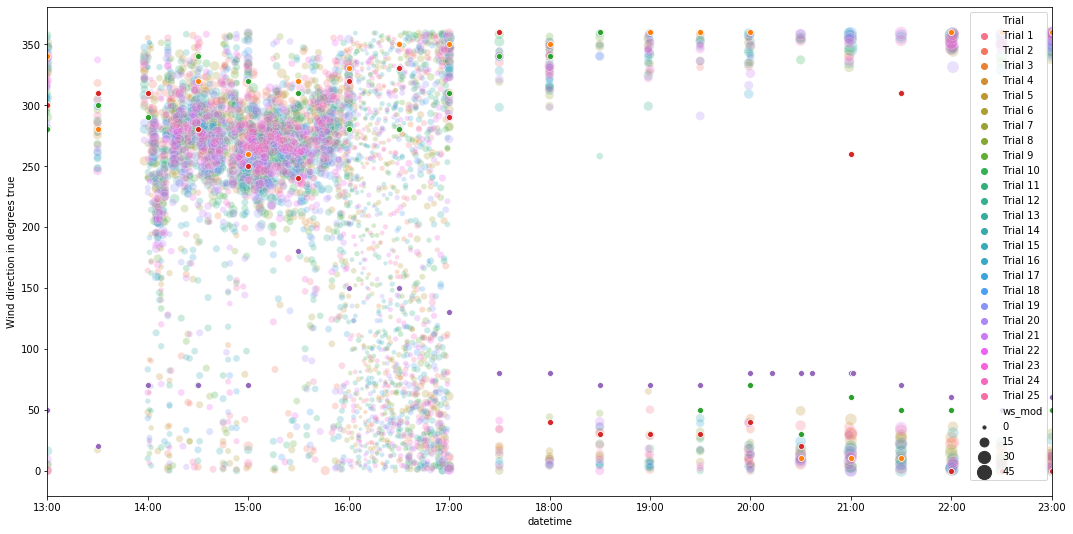

In [182]:
fig, ax = plt.subplots(figsize=(18,9))
ax = sns.scatterplot(x="datetime", y="wd_mod",
                  hue="Trial",size="ws_mod",alpha=0.25,sizes=(10, 200),# style="choice",
                  data=sabre_weather)
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))
handles = []
handles.append(sns.scatterplot(dalby['datetime'],dalby['Wind direction in degrees true']))
handles.append(sns.scatterplot(oakey['datetime'],oakey['Wind direction in degrees true']))
handles.append(sns.scatterplot(warwick['datetime'],warwick['Wind direction in degrees true']))
handles.append(sns.scatterplot(wellcamp['datetime'],wellcamp['Wind direction in degrees true']))
plt.show()

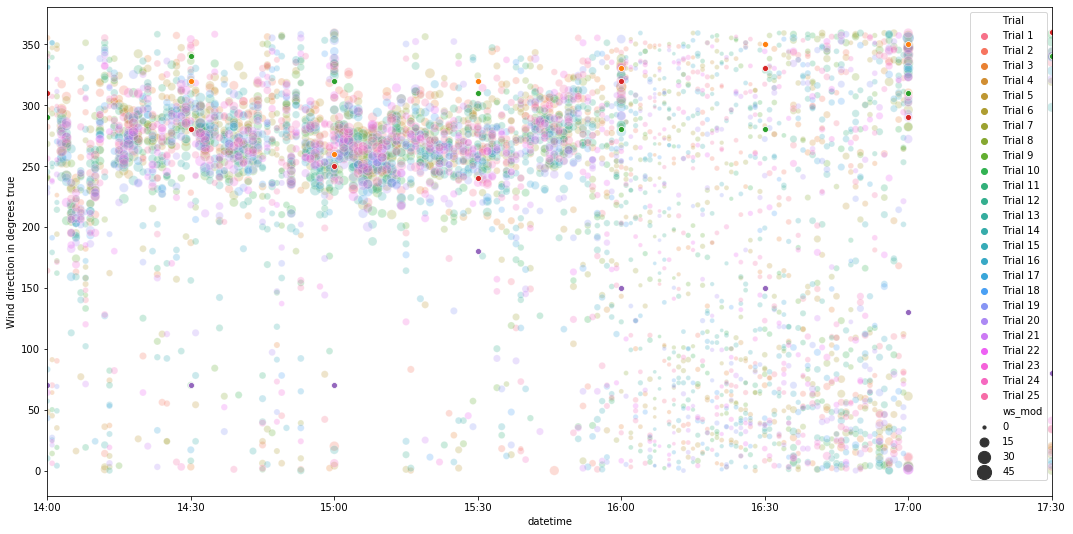

In [187]:
fig, ax = plt.subplots(figsize=(18,9))
ax = sns.scatterplot(x="datetime", y="wd_mod",
                  hue="Trial",size="ws_mod",alpha=0.25,sizes=(10, 200),# style="choice",
                  data=sabre_weather)
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))
handles = []
handles.append(sns.scatterplot(dalby['datetime'],dalby['Wind direction in degrees true']))
handles.append(sns.scatterplot(oakey['datetime'],oakey['Wind direction in degrees true']))
handles.append(sns.scatterplot(warwick['datetime'],warwick['Wind direction in degrees true']))
handles.append(sns.scatterplot(wellcamp['datetime'],wellcamp['Wind direction in degrees true']))
plt.xlim((pd.to_datetime('2016-12-05 14:00:00+10:00'),pd.to_datetime('2016-12-05 17:30:00+10:00')))

plt.show()

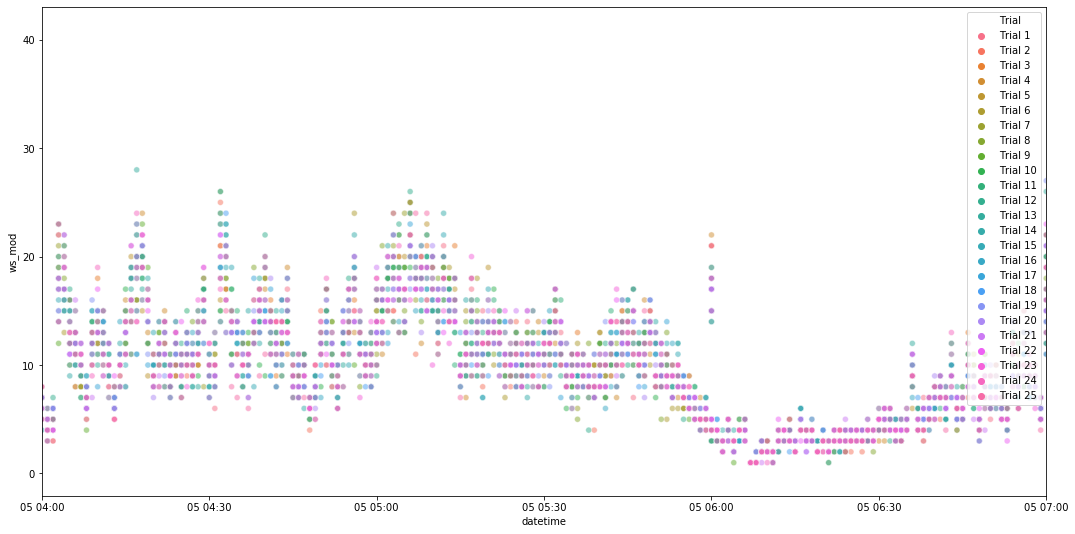

In [183]:
fig, ax = plt.subplots(figsize=(18,9))
ax = sns.scatterplot(x="datetime", y="ws_mod",
                  hue="Trial",alpha=0.5,# style="choice",
                  data=sabre_weather)
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
plt.show()

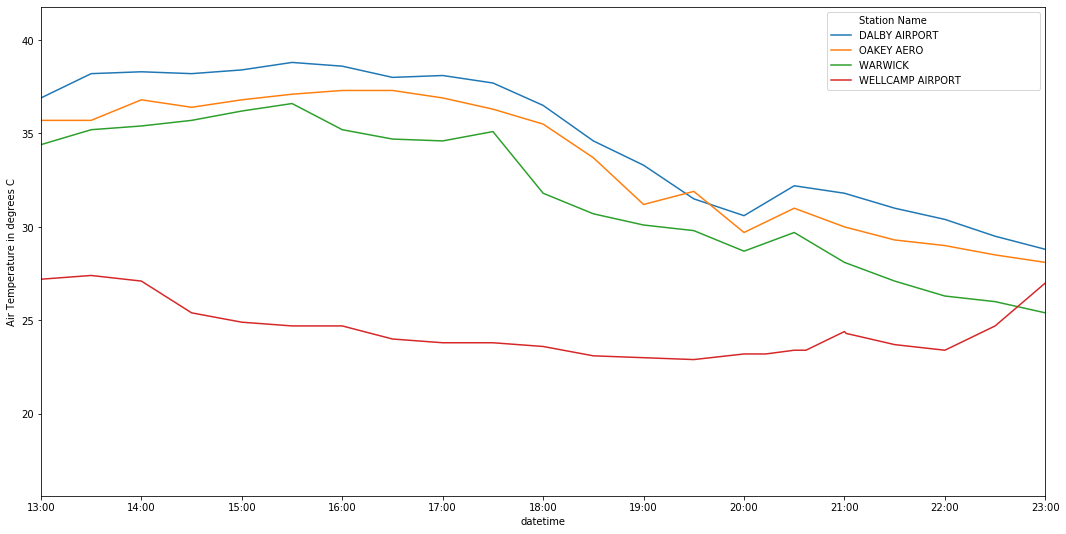

In [201]:
fig, ax = plt.subplots(figsize=(18,9))
ax = sns.lineplot(x="datetime", y="Air Temperature in degrees C",
                  hue="Station Name",#size="ws_mod",alpha=0.25,sizes=(10, 200),# style="choice",
                  data=bom_combined)
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))
plt.show()

In [191]:
bom_combined.columns

Index(['hm', 'Station Number', 'Station Name', 'datetime',
       'Precipitation since 9am local time in mm',
       'Air Temperature in degrees C', 'Dew point temperature in degrees C',
       'Relative humidity in percentage %', 'Wind speed in km/h',
       'Wind direction in degrees true',
       'Speed of maximum windgust in last 10 minutes in  km/h', '#'],
      dtype='object')

In [225]:
bom_combined = dalby.copy()
bom_combined = bom_combined.append(oakey)
bom_combined = bom_combined.append(warwick)
bom_combined = bom_combined.append(wellcamp)

sabre_bom_combined = bom_combined[['datetime',
                                   "Air Temperature in degrees C",
                                   'Relative humidity in percentage %',
                                   'Wind speed in km/h',
                                  'Station Name']].copy()
sabre_bom_combined['Trial'] = 'None'

sabre_weather_scalars = sabre_weather[['datetime','temperature_mod','rh_mod','ws_mod','Trial']].copy()
sabre_weather_scalars.rename(columns={'temperature_mod':'Air Temperature in degrees C',
                                     'rh_mod':'Relative humidity in percentage %',
                                     'ws_mod':'Wind speed in km/h'},inplace=True)
sabre_weather_scalars['Station Name'] = 'Trial (deploy AWS + )'

sabre_bom_combined = sabre_weather_scalars.append(sabre_bom_combined)

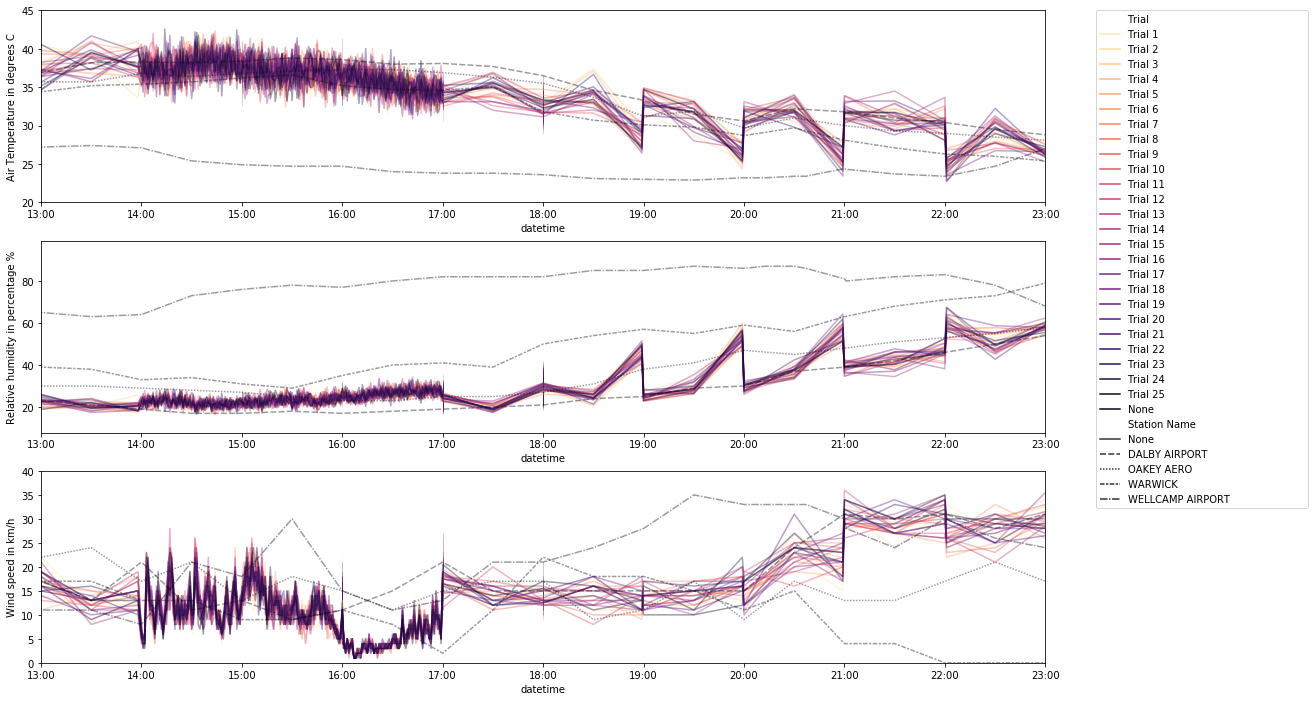

In [249]:
alpha = 0.4
xlims = (pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00'))

fig, ax = plt.subplots(figsize=(18,12))
ax1 = plt.subplot(311)
ax1 = sns.lineplot(x="datetime", y="Air Temperature in degrees C",
                  hue="Trial",
                  style='Station Name',
                  palette='magma_r',
                  #size="ws_mod",alpha=0.25,sizes=(10, 200),# style="choice",
                  alpha=alpha,
                  #legend='full',
                  data=sabre_bom_combined)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(xlims)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))
plt.ylim((20,45))

ax2 = plt.subplot(312)
ax2 = sns.lineplot(x="datetime", y="Relative humidity in percentage %",
                  hue="Trial",
                  style='Station Name',
                  palette='magma_r',
                  #size="ws_mod",alpha=0.25,sizes=(10, 200),# style="choice",
                  alpha=alpha,
                  legend=False,
                  data=sabre_bom_combined)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(xlims)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))

ax3 = plt.subplot(313)
ax3 = sns.lineplot(x="datetime", y="Wind speed in km/h",
                  hue="Trial",
                  style='Station Name',
                  palette='magma_r',
                  #size="ws_mod",alpha=0.25,sizes=(10, 200),# style="choice",
                  alpha=alpha,
                  legend=False,
                  data=sabre_bom_combined)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0,40))
plt.xlim(xlims)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))

plt.show()

No handles with labels found to put in legend.


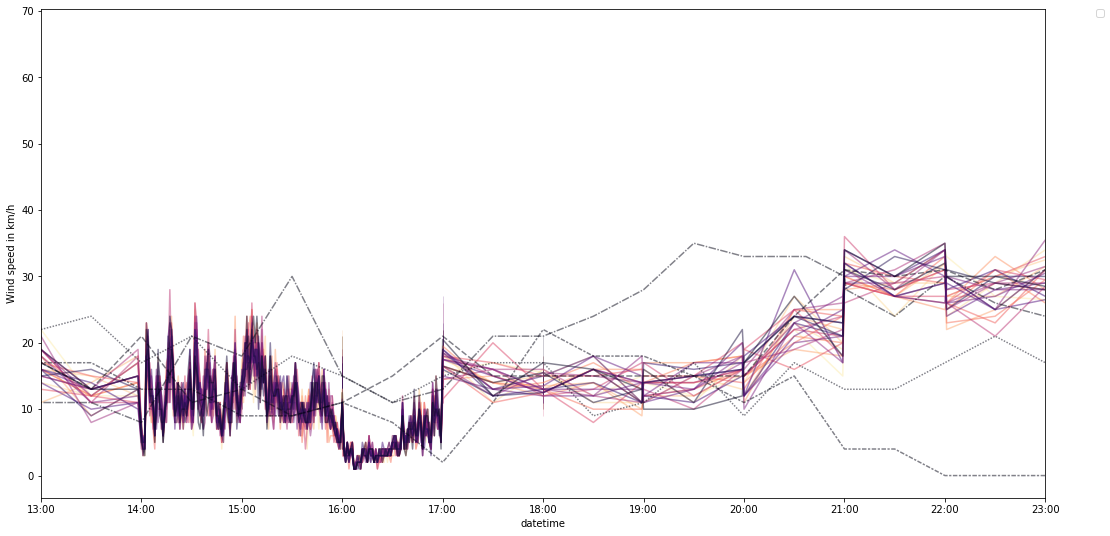

In [250]:
fig, ax = plt.subplots(figsize=(18,9))
#ax1 = plt.subplot(211)
ax = sns.lineplot(x="datetime", y="Wind speed in km/h",
                  hue="Trial",
                  style='Station Name',
                  palette='magma_r',
                  #size="ws_mod",alpha=0.25,sizes=(10, 200),# style="choice",
                  alpha=0.5,
                  legend=False,
                  data=sabre_bom_combined)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))

In [263]:
df['max'].unique()

array([16, 29, 31, 33, 34, 32, 30, 27, 25, 24, 22, 19,  8,  6,  7, 23, 17,
       12,  9, 15, 14, 21, 28, 13, 11, 26, 18, 10, 20,  5,  4,  1,  2,  3,
       36, 35, 41, 39,  0])

In [272]:
df = sabre_weather_scalars.groupby('datetime')['Wind speed in km/h'].agg(['min','max','mean','std']).reset_index()
df['top'] = df['mean'] + df['std']
df['bottom'] = df['mean'] - df['std']

In [294]:
from matplotlib.lines import Line2D

/Users/Fuego/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


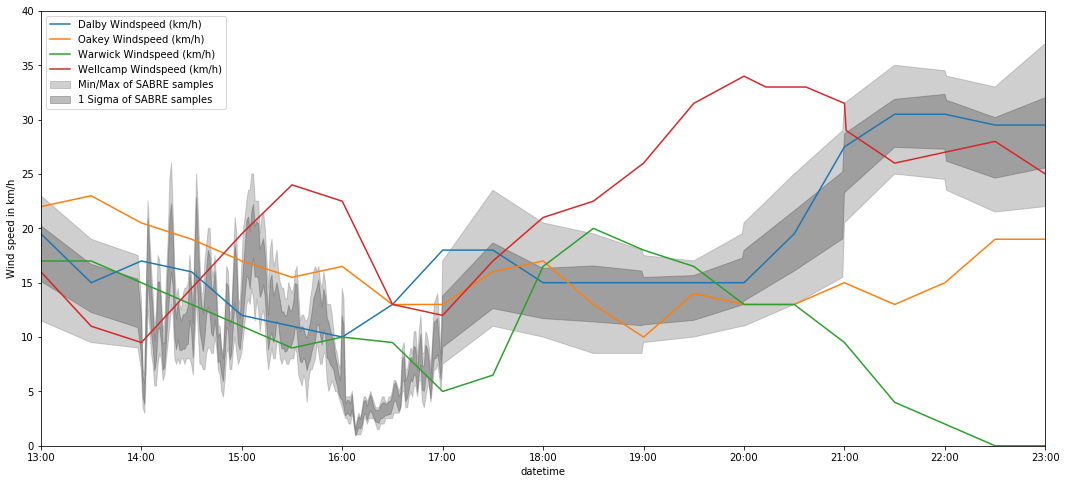

In [304]:
variable = 'Wind speed in km/h'
roll=2

fig, ax = plt.subplots(figsize=(18,8))
df = sabre_weather_scalars.groupby('datetime')[variable].agg(['min','max','mean','std']).reset_index()
df['top'] = df['mean'] + df['std']
df['bottom'] = df['mean'] - df['std']

#ax.fill_between(df.datetime, df['min'], df['max'], color='#888888', alpha=0.4)
#ax.fill_between(df.datetime, df['bottom'], df['top'], color='#888888', alpha=0.4)
ax.fill_between(df.datetime, df['min'].rolling(roll).mean(), df['max'].rolling(roll).mean(), color='#888888', alpha=0.4)
ax.fill_between(df.datetime, df['bottom'].rolling(roll).mean(), df['top'].rolling(roll).mean(), color='#595959', alpha=0.4)

handles = []
handles.append(sns.lineplot(dalby['datetime'],dalby[variable].rolling(roll).mean()))
handles.append(sns.lineplot(oakey['datetime'],oakey[variable].rolling(roll).mean()))
handles.append(sns.lineplot(warwick['datetime'],warwick[variable].rolling(roll).mean()))
handles.append(sns.lineplot(wellcamp['datetime'],wellcamp[variable].rolling(roll).mean()))

handles.append(Line2D([0], [0], color='#888888'))#, alpha=0.1))
handles.append(Line2D([0], [0], color='#595959'))#, alpha=0.8))

aws_locations = ['Dalby','Oakey','Warwick','Wellcamp']
labels = [x + ' Windspeed (km/h)' for x in aws_locations]
labels.extend(['Min/Max of SABRE samples','1 Sigma of SABRE samples'])
plt.legend(handles,labels=labels,loc='upper left')

plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
plt.ylim((0,40))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))

###  Residual Wind Direction

In [407]:
start, end = pd.to_datetime('2016-12-05 14:00:00+10:00'),pd.to_datetime('2016-12-05 17:00:00+10:00')

uq_weather = sabre_weather[sabre_weather.Trial == sabre_weather.Trial.unique()[1]].copy()
uq_weather['datetime'] = uq_weather.datetime.drop_duplicates()

uq_weather = uq_weather.set_index(['datetime'])
uq_weather = uq_weather.loc[start:end]

In [ ]:
def mean_wd(WS,WD):
    V_east = np.mean(WS[i] * np.sin(WD * np.pi/180))
    V_north = np.mean(WS * np.cos(WD * np.pi/180))

    mean_WD = np.arctan2(V_east, V_north) * 180/np.pi
    return (360 + mean_WD) % 360

Mean UQ wind direction = 283.7907018011179
Mean Dalby wind direction = 305.1187115397143
Mean residual wind direction = 27.1878453038674


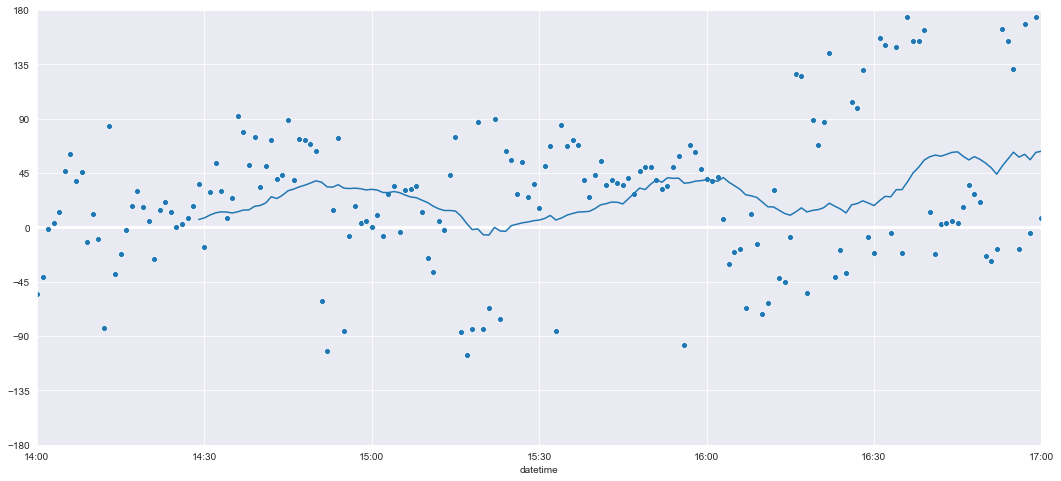

In [425]:
fig, ax = plt.subplots(figsize=(18,8))

dalby_wd = dalby_1min.loc[start:end]['Wind (1 minute) direction in degrees true']
uq_wd = uq_weather.wd

residual = dalby_wd + 180 - uq_wd - 180
residual[residual > 180] = residual[residual > 180] - 180
residual[residual < -180] = residual[residual < -180] + 180

lm_df = pd.DataFrame({'datetime':uq_weather.index,'residual':residual})
#lm_df.set_index('datetime')

sns.set_style("darkgrid")
plt.plot([start,end],[0, 0],linewidth=3,color='white',zorder=0)
sns.scatterplot(uq_weather.index,residual)
sns.lineplot(uq_weather.index,residual.rolling(30).mean())
#sns.lmplot(x='datetime',y='residual',data=lm_df)

dalby_ws = dalby_1min.loc[start:end]['Wind (1 minute) speed in km/h']

print('Mean UQ wind direction = {}'.format(mean_wd(uq_weather.ws,uq_weather.wd)))
print('Mean Dalby wind direction = {}'.format(mean_wd(dalby_ws,dalby_wd)))

print('Mean residual wind direction = {}'.format(np.mean(residual)))

plt.xlim((start,end))
plt.ylim((-180,180))
plt.yticks(np.linspace(-180,180,9))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))

## Combine all meteogram-type plots

In [472]:
from string import ascii_lowercase as alphabet

/Users/Fuego/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/Users/Fuego/.local/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


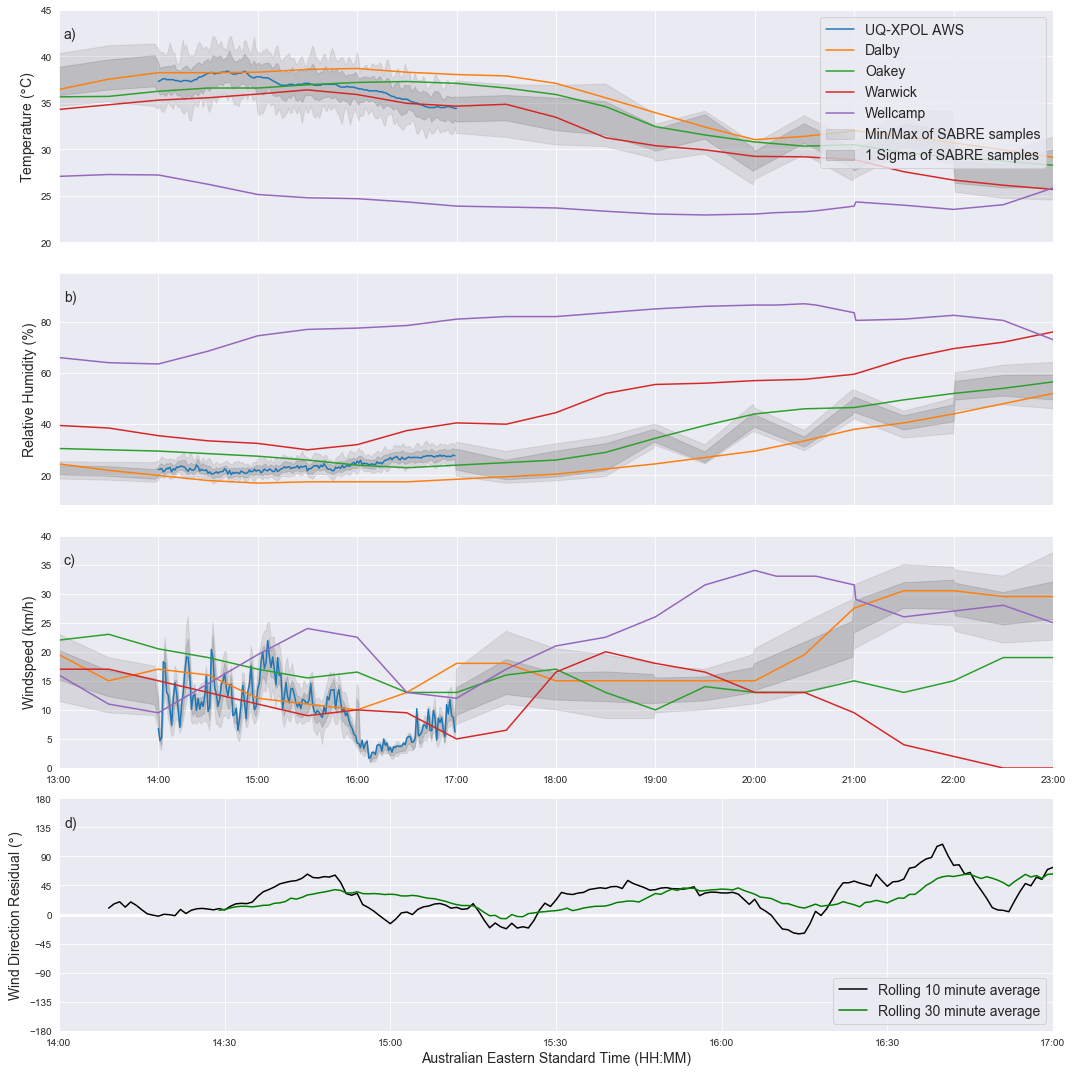

In [507]:
roll=2
fontsize=14
alpha=0.2

fig, ax = plt.subplots(figsize=(15,15))

ax1 = plt.subplot(411)
variable = 'Air Temperature in degrees C'

df = sabre_weather_scalars.groupby('datetime')[variable].agg(['min','max','mean','std']).reset_index()
df['top'] = df['mean'] + df['std']
df['bottom'] = df['mean'] - df['std']
ax1.fill_between(df.datetime, df['min'].rolling(roll).mean(), df['max'].rolling(roll).mean(), color='#888888', alpha=alpha)
ax1.fill_between(df.datetime, df['bottom'].rolling(roll).mean(), df['top'].rolling(roll).mean(), color='#595959', alpha=alpha)
handles = []
handles.append(sns.lineplot(uq_weather.index,uq_weather['temperature']))
handles.append(sns.lineplot(dalby['datetime'],dalby[variable].rolling(roll).mean()))
handles.append(sns.lineplot(oakey['datetime'],oakey[variable].rolling(roll).mean()))
handles.append(sns.lineplot(warwick['datetime'],warwick[variable].rolling(roll).mean()))
handles.append(sns.lineplot(wellcamp['datetime'],wellcamp[variable].rolling(roll).mean()))
handles.append(Line2D([0], [0], color='#888888'))#, alpha=0.1))
handles.append(Line2D([0], [0], color='#595959'))#, alpha=0.8))

labels = ['UQ-XPOL AWS','Dalby','Oakey','Warwick','Wellcamp','Min/Max of SABRE samples','1 Sigma of SABRE samples']
#labels = [x + ' Windspeed (km/h)' for x in aws_locations]
#labels.extend(['Min/Max of SABRE samples','1 Sigma of SABRE samples'])
plt.legend(handles,labels=labels,loc='upper right', fontsize=fontsize)

#aws_locations = ['Dalby','Oakey','Warwick','Wellcamp']
#labels = [x + ' Windspeed (km/h)' for x in aws_locations]
#labels.extend(['Min/Max of SABRE samples','1 Sigma of SABRE samples'])
#plt.legend(handles,labels=labels,loc='upper left')
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax1.set_xticks([])
ax1.text(pd.to_datetime('2016-12-05 13:03:00+10:00'),42.,'{})'.format(alphabet[0]),horizontalalignment='left', fontsize=fontsize)
plt.ylabel('Temperature ($\degree$C)', fontsize=fontsize)

#ax1.text(.025,.9,'{})'.format(alphabet[0]),horizontalalignment='left')
plt.ylim((20,45))
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))


ax2 = plt.subplot(412,sharex=ax1)
variable = 'Relative humidity in percentage %'

df = sabre_weather_scalars.groupby('datetime')[variable].agg(['min','max','mean','std']).reset_index()
df['top'] = df['mean'] + df['std']
df['bottom'] = df['mean'] - df['std']
ax2.fill_between(df.datetime, df['min'].rolling(roll).mean(), df['max'].rolling(roll).mean(), color='#888888', alpha=alpha)
ax2.fill_between(df.datetime, df['bottom'].rolling(roll).mean(), df['top'].rolling(roll).mean(), color='#595959', alpha=alpha)
handles = []
handles.append(sns.lineplot(uq_weather.index[:-1],uq_weather['rh'][:-1]))
handles.append(sns.lineplot(dalby['datetime'],dalby[variable].rolling(roll).mean()))
handles.append(sns.lineplot(oakey['datetime'],oakey[variable].rolling(roll).mean()))
handles.append(sns.lineplot(warwick['datetime'],warwick[variable].rolling(roll).mean()))
handles.append(sns.lineplot(wellcamp['datetime'],wellcamp[variable].rolling(roll).mean()))
handles.append(Line2D([0], [0], color='#888888'))#, alpha=0.1))
handles.append(Line2D([0], [0], color='#595959'))#, alpha=0.8))

#aws_locations = ['Dalby','Oakey','Warwick','Wellcamp']
#labels = [x + ' Windspeed (km/h)' for x in aws_locations]
#labels.extend(['Min/Max of SABRE samples','1 Sigma of SABRE samples'])
#plt.legend(handles,labels=labels,loc='upper left')
#plt.legend(handles,labels=aws_locations,loc='upper right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.text(pd.to_datetime('2016-12-05 13:03:00+10:00'),88.,'{})'.format(alphabet[1]),horizontalalignment='left', fontsize=fontsize)
plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
ax2.set_xticks([])
plt.ylabel('Relative Humidity (%)', fontsize=fontsize)

#plt.set_xticks([])
#plt.ylim((0,40))
#ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))

ax3 = plt.subplot(413,sharex=ax1)
variable = 'Wind speed in km/h'

df = sabre_weather_scalars.groupby('datetime')[variable].agg(['min','max','mean','std']).reset_index()
df['top'] = df['mean'] + df['std']
df['bottom'] = df['mean'] - df['std']
ax3.fill_between(df.datetime, df['min'].rolling(roll).mean(), df['max'].rolling(roll).mean(), color='#888888', alpha=alpha)
ax3.fill_between(df.datetime, df['bottom'].rolling(roll).mean(), df['top'].rolling(roll).mean(), color='#595959', alpha=alpha)

handles = []
handles.append(sns.lineplot(uq_weather.index[:-1],uq_weather['ws'][:-1]))
handles.append(sns.lineplot(dalby['datetime'],dalby[variable].rolling(roll).mean()))
handles.append(sns.lineplot(oakey['datetime'],oakey[variable].rolling(roll).mean()))
handles.append(sns.lineplot(warwick['datetime'],warwick[variable].rolling(roll).mean()))
handles.append(sns.lineplot(wellcamp['datetime'],wellcamp[variable].rolling(roll).mean()))

handles.append(Line2D([0], [0], color='#888888'))#, alpha=0.1))
handles.append(Line2D([0], [0], color='#595959'))#, alpha=0.8))


#,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlim((pd.to_datetime('2016-12-05 13:00:00+10:00'),pd.to_datetime('2016-12-05 23:00:00+10:00')))
plt.ylim((0,40))
ax3.text(pd.to_datetime('2016-12-05 13:03:00+10:00'),35.,'{})'.format(alphabet[2]),horizontalalignment='left', fontsize=fontsize)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.xaxis.label.set_visible(False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.xaxis.label.set_visible(False)
ax3.xaxis.label.set_visible(False)
plt.ylabel('Windspeed (km/h)', fontsize=fontsize)

#ax3.text(.025,.9,'{})'.format(alphabet[2]),horizontalalignment='left')



#plt.setp(ax1.get_xticklabels(), visible=False)



ax4 = plt.subplot(414)
handles = []
#handles.append(sns.scatterplot(uq_weather.index,residual,color='k'))
handles.append(sns.lineplot(uq_weather.index,residual.rolling(10).mean(),color='k'))
handles.append(sns.lineplot(uq_weather.index,residual.rolling(30).mean(),color='g'))

plt.xlim((start,end))
plt.ylim((-180,180))
plt.yticks(np.linspace(-180,180,9))

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M',tz=tz.gettz('Australia/Brisbane')))
ax4.text(pd.to_datetime('2016-12-05 14:01:00+10:00'),135.,'{})'.format(alphabet[3]),horizontalalignment='left', fontsize=fontsize)
#plt.legend(handles,labels=['Rolling 10 minute average','1 minute observations'],loc='lower right', fontsize=fontsize)
plt.legend(handles,labels=['Rolling 10 minute average','Rolling 30 minute average'],loc='lower right', fontsize=fontsize)

plt.plot([start,end],[0, 0],linewidth=3,color='white',zorder=0)

plt.xlabel('Australian Eastern Standard Time (HH:MM)', fontsize=fontsize)
plt.ylabel('Wind Direction Residual ($\degree$)', fontsize=fontsize)
#ax4.text(.025,.9,'{})'.format(alphabet[3]),horizontalalignment='left')

plt.tight_layout()
plt.savefig('./meteogram.png',dpi=300)
plt.show()

# Fire Severity

In [30]:
fire_severity = gpd.read_file('./datasets/shapefiles/FireSeverity.shp')
crowned_areas = fire_severity[fire_severity['Crowned'] == 'Crowned']
crowned_areas = crowned_areas.to_crs(Sedgerly_5Dec1215To1900.crs)
crowned_areas_SABRE = gpd.sjoin(Sedgerly_5Dec1215To1900, crowned_areas, how="inner", op='intersects')

In [31]:
crowned_areas_SABRE['crowning_area'] = crowned_areas_SABRE.area

In [32]:
crowned_areas_SABRE_mean = crowned_areas_SABRE.resample('T', on='Time_obj').mean()
resampled_std = crowned_areas_SABRE.resample('T', on='Time_obj').std() #.dropna(how='all')
crowned_areas_SABRE_mean_std = crowned_areas_SABRE_mean.join(resampled_std,lsuffix='_mean',rsuffix='_std')

crowned_areas_SABRE_sum = crowned_areas_SABRE.resample('T', on='Time_obj').sum()


In [38]:
crowned_areas_SABRE_count = crowned_areas_SABRE.resample('T', on='Time_obj').count()
no_trials = len(Sedgerly_5Dec1215To1900.Trial_Name.unique())
crowned_areas_SABRE_count['Percentage_Crowning'] = (crowned_areas_SABRE_count.Trial_Name/no_trials)#*100
#crowned_areas_SABRE_count['Time'] = crowned_areas_SABRE_count['Time_obj']
#crowned_areas_SABRE_count.reset_index(inplace=False)
crowned_areas_SABRE_sum['mean_crowning'] = crowned_areas_SABRE_sum.crowning_area/no_trials

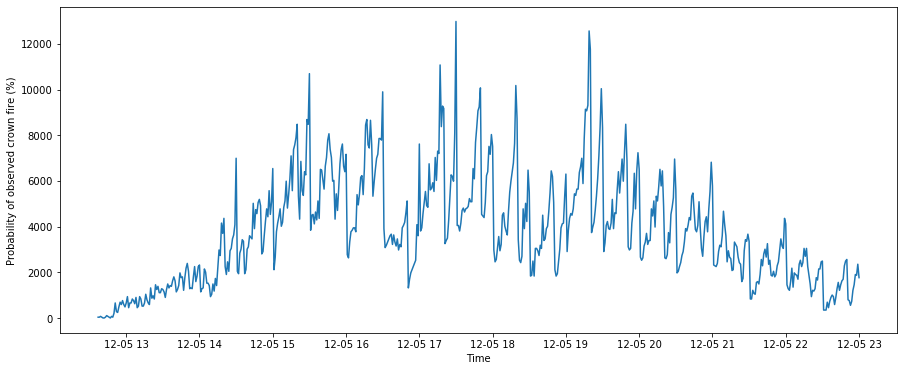

In [39]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(crowned_areas_SABRE_count.index,crowned_areas_SABRE_sum.crowning_area/no_trials)
plt.xlabel('Time')
plt.ylabel('Probability of observed crown fire (%)')
#ax.xaxis.set_major_formatter(crowned_areas_SABRE_count.index.DateFormatter('%t')
plt.show()

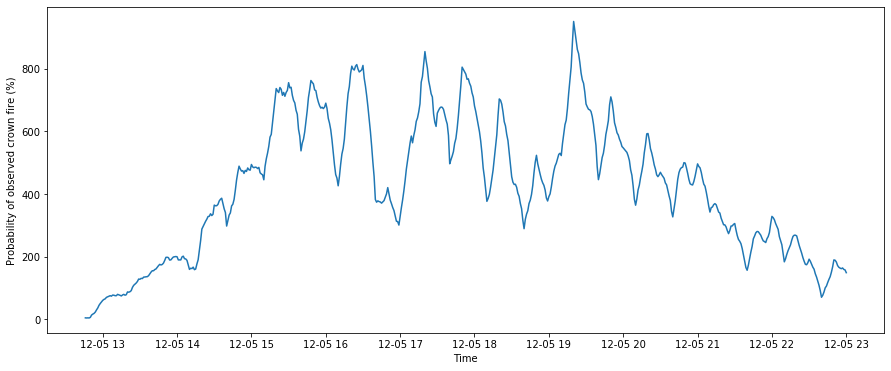

In [35]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(crowned_areas_SABRE_count.index,crowned_areas_SABRE_count.Percentage_Crowning.rolling(10).mean())
plt.xlabel('Time')
plt.ylabel('Probability of observed crown fire (%)')
#ax.xaxis.set_major_formatter(crowned_areas_SABRE_count.index.DateFormatter('%t')
plt.show()

In [36]:
crowned_areas_SABRE_count.to_pickle('./datasets/crowning_intersected_SABRE_count.pkl')
crowned_areas_SABRE.to_pickle('./datasets/crowning_intersected_SABRE.pkl')
crowned_areas_SABRE.to_pickle('./datasets/crowning_intersected_SABRE.pkl')

In [37]:
#crowned_areas_SABRE.groupby('Trial_Name').agg('cumsum').

## Load radar data

In [26]:
radar_mean = pd.read_hdf('./datasets/Sedgerly_5th_mean.h5')
radar_max = pd.read_hdf('./datasets/Sedgerly_5th_max.h5')
radar_count = pd.read_hdf('./datasets/Sedgerly_5th_count.h5')
radar_hdf = pd.read_hdf('./datasets/Sedgerly_5th.h5')

KeyboardInterrupt: 

In [24]:
radar_hdf.head()

NameError: name 'radar_hdf' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(radar_hdf.index,radar_hdf.DBZH)
plt.xlabel('Time')
plt.ylabel('Reflectivity')
#ax.xaxis.set_major_formatter(crowned_areas_SABRE_count.index.DateFormatter('%t')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))


ax1 = plt.subplot(311)
sns.lineplot(Sedgerly_mean_std.Time_obj,Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean())
plt.setp(ax1.get_xticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('Mean Flame height')

ax2 = plt.subplot(312, sharex=ax1)
sns.lineplot(crowned_areas_SABRE_sum.index,crowned_areas_SABRE_sum.mean_crowning.rolling(5).mean())
#sns.lineplot(crowned_areas_SABRE_count.index,crowned_areas_SABRE_count.Percentage_Crowning.rolling(10).mean())
plt.ylabel('Rolling mean of crowning in sqm')
#sns.lineplot(radar_max.index,radar_max.DBZH)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.xlabel('')


ax3 = plt.subplot(313, sharex=ax1)
#fig, ax = plt.subplots(3,1,'all',figsize=(12,6))
sns.lineplot(radar_mean.index,radar_mean.DBZH,color='b')
plt.ylabel('Mean dBZ',color='b')
plt.xlabel('Time')

ax4 = ax3.twinx()
sns.lineplot(radar_count.index,radar_count.DBZH,color='r')
plt.ylabel('Radar Pixel Count',color='r')
#ax.fill_between(Sedgerly_mean_std.Time_obj,cis[1],cis[0],alpha=0.2)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))


ax1 = plt.subplot(311)
sns.lineplot(Sedgerly_mean_std.Time_obj,Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean())
plt.setp(ax1.get_xticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('Mean Flame height')

ax2 = plt.subplot(312, sharex=ax1)
sns.lineplot(crowned_areas_SABRE_sum.index,crowned_areas_SABRE_sum.mean_crowning.rolling(5).mean())
#sns.lineplot(crowned_areas_SABRE_count.index,crowned_areas_SABRE_count.Percentage_Crowning.rolling(10).mean())
plt.ylabel('Rolling mean of crowning in sqm')
#sns.lineplot(radar_max.index,radar_max.DBZH)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.xlabel('')


ax3 = plt.subplot(313, sharex=ax1)
#fig, ax = plt.subplots(3,1,'all',figsize=(12,6))
sns.lineplot(radar_mean.index,radar_mean.DBZH,color='b')
plt.ylabel('Mean dBZ',color='b')
plt.xlabel('Time')

ax4 = ax3.twinx()
sns.lineplot(radar_count.index,radar_count.DBZH,color='r')
plt.ylabel('Radar Pixel Count',color='r')
#ax.fill_between(Sedgerly_mean_std.Time_obj,cis[1],cis[0],alpha=0.2)
ax4.set_xlim(['2016-12-05 15:58:00','2016-12-05 19:16:00'])
plt.show()

In [ ]:
dalby_obs = pd.read_csv('./WeatherData1_Dalby_1min/HD01D_Data_041522_999999999520484.txt')

In [ ]:
dalby_obs.head()

In [ ]:
dalby_obs.columns

In [ ]:
dalby_obs['datetime'] = pd.to_datetime(dalby_obs[' Year Month Day Hour Minutes in YYYY'].astype(str) + '-' +
                        dalby_obs['MM'].astype(str) + '-' +
                        dalby_obs['DD'].astype(str) + ' ' +
                        dalby_obs['HH24'].astype(str) + ':' + 
                        dalby_obs['MI format in Local standard time'].astype(str))

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))


ax1 = plt.subplot(411)
sns.lineplot(Sedgerly_mean_std.Time_obj,Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean())
plt.setp(ax1.get_xticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('Mean Flame height')

ax2 = plt.subplot(412, sharex=ax1)
sns.lineplot(crowned_areas_SABRE_sum.index,crowned_areas_SABRE_sum.mean_crowning.rolling(5).mean())
#sns.lineplot(crowned_areas_SABRE_count.index,crowned_areas_SABRE_count.Percentage_Crowning.rolling(10).mean())
plt.ylabel('Rolling mean of crowning in sqm')
#sns.lineplot(radar_max.index,radar_max.DBZH)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.xlabel('')


ax3 = plt.subplot(413, sharex=ax1)
#fig, ax = plt.subplots(3,1,'all',figsize=(12,6))
sns.lineplot(radar_mean.index,radar_mean.DBZH,color='b')
plt.ylabel('Mean dBZ',color='b')
plt.xlabel('Time')

ax4 = ax3.twinx()
sns.lineplot(radar_count.index,radar_count.DBZH,color='r')
plt.ylabel('Radar Pixel Count',color='r')
#ax.fill_between(Sedgerly_mean_std.Time_obj,cis[1],cis[0],alpha=0.2)
#ax4.set_xlim(['2016-12-05 15:58:00','2016-12-05 19:16:00'])

ax5 = plt.subplot(414, sharex=ax1)
sns.lineplot(dalby_obs['datetime'],dalby_obs['Air Temperature in degrees Celsius'],color='r')
sns.lineplot(dalby_obs['datetime'],dalby_obs['Dew point temperature in degrees Celsius'],color='b')

plt.ylabel('Temperature',color='b')
plt.xlabel('Time')
ax5.set_xlim(['2016-12-05 15:58:00','2016-12-05 19:16:00'])

plt.show()

In [ ]:
UQ_obs = pd.read_csv('./SedgerlyFireAWS.csv')

In [ ]:
UQ_obs['datetime'] = pd.to_datetime(UQ_obs['date'] + ' ' + UQ_obs['time'])
UQ_obs.rename(index=str,columns={'Air_Temp (degC)': 'temperature', 'Humidity (%RH)': 'rh'},inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))


ax1 = plt.subplot(411)
sns.lineplot(Sedgerly_mean_std.Time_obj,Sedgerly_mean_std.FLAME_HT_mean.rolling(10).mean())
plt.setp(ax1.get_xticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('Mean Flame height')

ax2 = plt.subplot(412, sharex=ax1)
sns.lineplot(crowned_areas_SABRE_sum.index,crowned_areas_SABRE_sum.mean_crowning.rolling(5).mean())
#sns.lineplot(crowned_areas_SABRE_count.index,crowned_areas_SABRE_count.Percentage_Crowning.rolling(10).mean())
plt.ylabel('Rolling mean of crowning in sqm')
#sns.lineplot(radar_max.index,radar_max.DBZH)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.xlabel('')


ax3 = plt.subplot(413, sharex=ax1)
#fig, ax = plt.subplots(3,1,'all',figsize=(12,6))
sns.lineplot(radar_mean.index,radar_mean.DBZH,color='b')
plt.ylabel('Mean dBZ',color='b')
plt.xlabel('Time')

ax4 = ax3.twinx()
sns.lineplot(radar_count.index,radar_count.DBZH,color='r')
plt.ylabel('Radar Pixel Count',color='r')
#ax.fill_between(Sedgerly_mean_std.Time_obj,cis[1],cis[0],alpha=0.2)
#ax4.set_xlim(['2016-12-05 15:58:00','2016-12-05 19:16:00'])

ax5 = plt.subplot(414, sharex=ax1)
sns.lineplot(UQ_obs['datetime'],UQ_obs['temperature'],color='r')
#sns.lineplot(UQ_obs['datetime'],dalby_obs['Dew point temperature in degrees Celsius'],color='b')

plt.ylabel('Temperature',color='b')
plt.xlabel('Time')

#ax6 = ax5.twinx()
#sns.lineplot(UQ_obs['datetime'],UQ_obs['rh'],color='b')
#plt.ylabel('Radar Pixel Count',color='r')

ax5.set_xlim(['2016-12-05 15:58:00','2016-12-05 19:16:00'])

plt.show()